# RAIL Prior

In [1]:
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.stats as stats
import qp

import nz_prior as nzp

## Load Data

In [2]:
dummy = np.load('../tests/dummy.npz')
zs = dummy['zs']
nzs = dummy['pzs']
dz = np.mean(np.diff(zs))
zs_edges = np.append(zs - dz/2, zs[-1] + dz/2)
q = qp.Ensemble(qp.hist, data={"bins":zs_edges, "pdfs":nzs})

In [3]:
base = nzp.PriorBase(q)

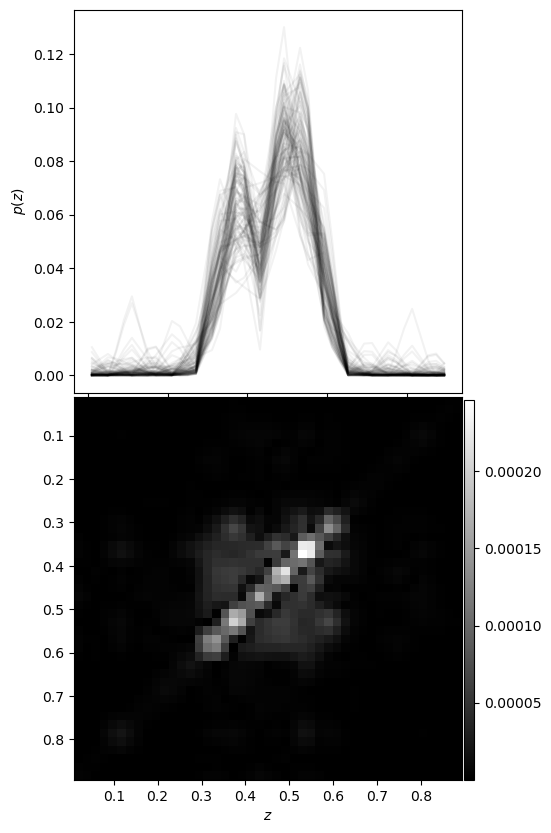

In [4]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    axis[0].plot(base.z, base.nzs[i], 'k-', alpha=0.05)
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(base.nz_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(zs), max(zs), max(zs), min(zs)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
plt.show()

# Shifts

In [5]:
shifts = nzp.PriorShifts(q)

In [6]:
pz_fid = [shifts.z, shifts.nz_mean]

In [7]:
shifted_nzs = np.array([nzp.shift_model(pz_fid, shifts.sample_prior()["delta_z"])[1] for i in range(100)])

In [8]:
shifted_cov = np.cov(shifted_nzs.T)

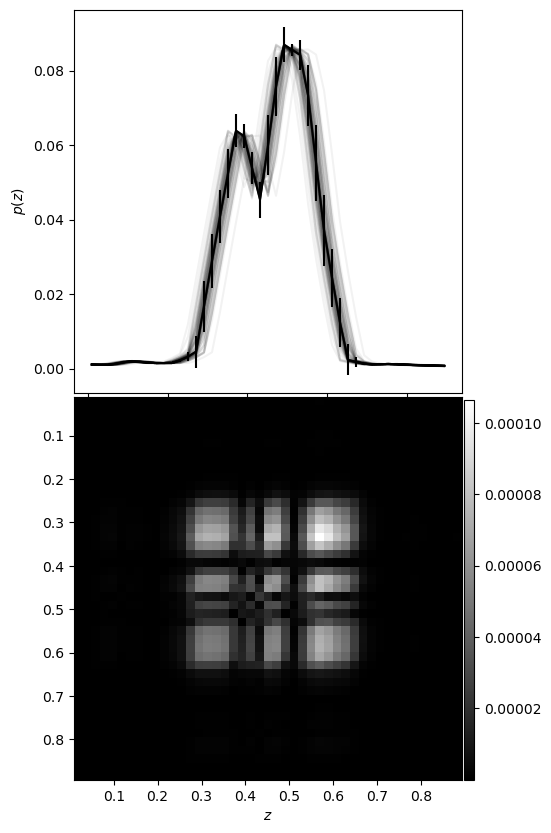

In [9]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    pz = shifted_nzs[i]
    axis[0].plot(shifts.z, pz, 'k-', alpha=0.05)
axis[0].errorbar(shifts.z, shifts.nz_mean, yerr=np.sqrt(np.diag(shifted_cov)), fmt='k-')
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(shifted_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(zs), max(zs), max(zs), min(zs)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
#plt.savefig('docs/source/assets/shifts.png')
plt.show()

# Shifts & Widths

In [10]:
SnW = nzp.PriorShiftsWidths(q)

In [11]:
SnW_nzs = []
for i in range(100):
    prior_sample = SnW.sample_prior()
    shift = prior_sample["delta_z"]
    width = prior_sample["width_z"]
    pz = nzp.shift_and_width_model(pz_fid, shift, width)[1]
    SnW_nzs.append(pz)
SnW_nzs = np.array(SnW_nzs)

In [12]:
SnW_cov = np.cov(SnW_nzs.T)

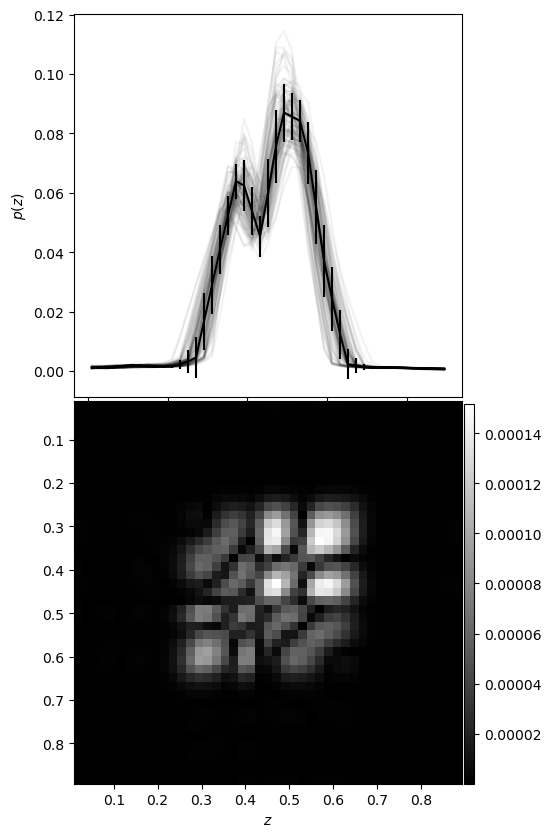

In [13]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    axis[0].plot(SnW.z, SnW_nzs[i], 'k-', alpha=0.05)
axis[0].errorbar(SnW.z, SnW.nz_mean, yerr=np.sqrt(np.diag(SnW_cov)), fmt='k-')
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(SnW_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(zs), max(zs), max(zs), min(zs)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
#plt.savefig('docs/source/assets/moments.png')
plt.show()

# Moments

In [14]:
moments = nzp.PriorMoments(q)

In [15]:
moments._get_params_names()

['nz_0',
 'nz_1',
 'nz_2',
 'nz_3',
 'nz_4',
 'nz_5',
 'nz_6',
 'nz_7',
 'nz_8',
 'nz_9',
 'nz_10',
 'nz_11',
 'nz_12',
 'nz_13',
 'nz_14',
 'nz_15',
 'nz_16',
 'nz_17',
 'nz_18',
 'nz_19',
 'nz_20',
 'nz_21',
 'nz_22',
 'nz_23',
 'nz_24',
 'nz_25',
 'nz_26',
 'nz_27',
 'nz_28',
 'nz_29',
 'nz_30',
 'nz_31',
 'nz_32',
 'nz_33',
 'nz_34',
 'nz_35',
 'nz_36',
 'nz_37',
 'nz_38',
 'nz_39',
 'nz_40',
 'nz_41',
 'nz_42',
 'nz_43',
 'nz_44']

In [16]:
moments_nzs = np.array([list(moments.sample_prior().values()) for i in range(100)])

The covariance matrix will be regularized
The covariance matrix will be diagonalized


In [17]:
moments_cov = np.cov(moments_nzs.T)

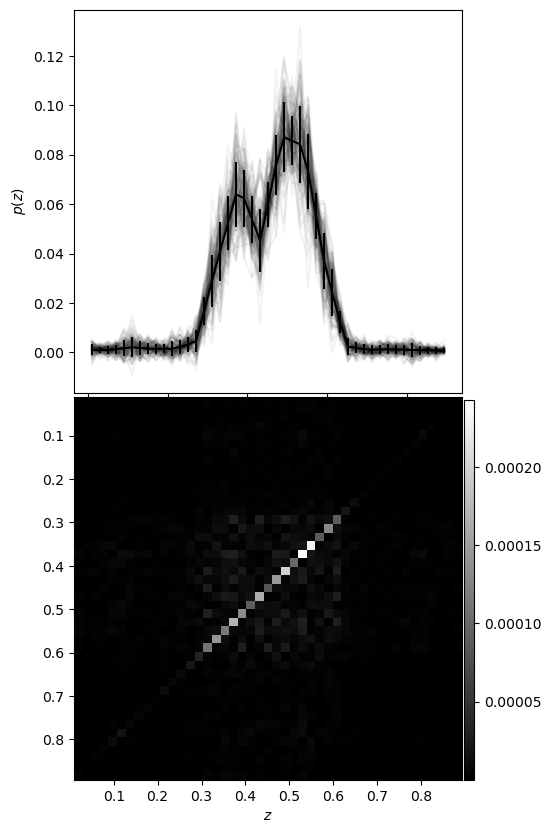

In [18]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    axis[0].plot(moments.z, moments_nzs[i], 'k-', alpha=0.05)
axis[0].errorbar(moments.z, moments.nz_mean, yerr=np.sqrt(np.diag(moments_cov)), fmt='k-')
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(moments_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(zs), max(zs), max(zs), min(zs)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
#plt.savefig('docs/source/assets/moments.png')
plt.show()

# Comb

In [19]:
M = 10
comb = nzp.PriorComb(q, ncombs=M)

In [20]:
comb._get_params_names()

['W_0', 'W_1', 'W_2', 'W_3', 'W_4', 'W_5', 'W_6', 'W_7', 'W_8', 'W_9']

In [21]:
comb.sample_prior().values()

The covariance matrix will be regularized


dict_values([0.002649212574525676, 0.008190501206311908, 0.023744867521743263, 0.14042927817240183, 0.23129988574758642, 0.3232781438583193, 0.22726151007338224, 0.040407022569507706, 0.0012237843886700366, 0.001515803851843895])

In [22]:
comb_nzs = []
for i in range(100):
    prior_sample = comb.sample_prior()
    W = np.array([prior_sample[name] for name in comb._get_params_names()])
    pz = nzp.comb_model(pz_fid, W)[1]
    comb_nzs.append(pz)
comb_nzs = np.array(comb_nzs)

In [23]:
comb_cov = np.cov(comb_nzs.T)

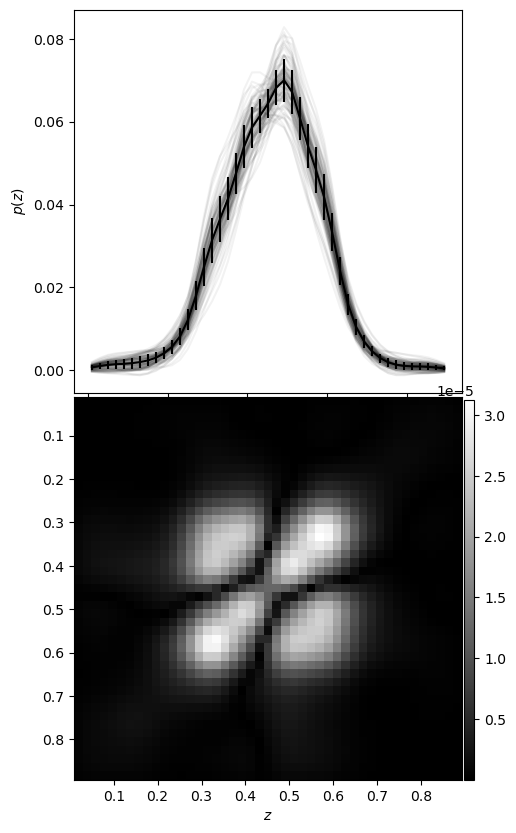

In [24]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    axis[0].plot(comb.z, comb_nzs[i], 'k-', alpha=0.05)
axis[0].errorbar(comb.z, np.mean(comb_nzs, axis=0),
                 yerr=np.sqrt(np.diag(comb_cov)),
                 fmt='k-')
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(comb_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(zs), max(zs), max(zs), min(zs)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
#plt.savefig('docs/source/assets/moments.png')
plt.show()